In [134]:
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint_MLP.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
EPOCHS = 10

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [104]:
train_dataset_imbalanced, _ = utils.create_train_dataset_imbalanced(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset_imbalanced, validation_dataset_imbalanced, _ = utils.create_test_dataset_imbalanced(validation_split=0.3)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 26821, 1: 27295, 2: 5884}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 26821 campioni (44.70%)
Relazione 1: 27295 campioni (45.49%)
Relazione 2: 5884 campioni (9.81%)




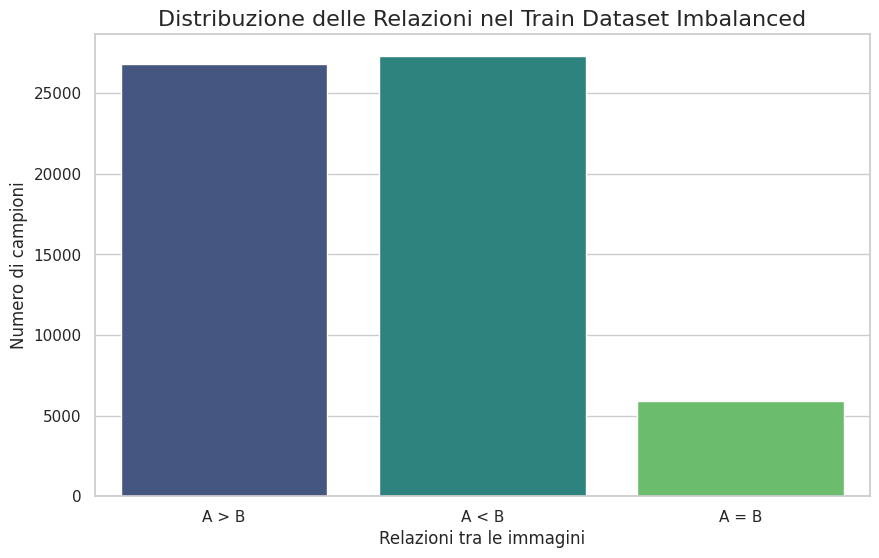

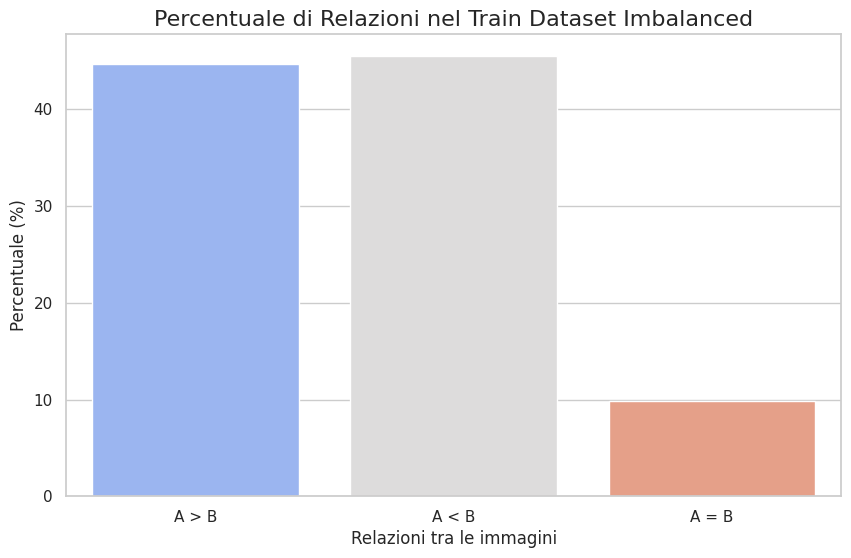

In [105]:
utils.plot_dataset_statistics(train_dataset_imbalanced, "Train Dataset Imbalanced")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 3153, 1: 3164, 2: 683}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 3153 campioni (45.04%)
Relazione 1: 3164 campioni (45.20%)
Relazione 2: 683 campioni (9.76%)




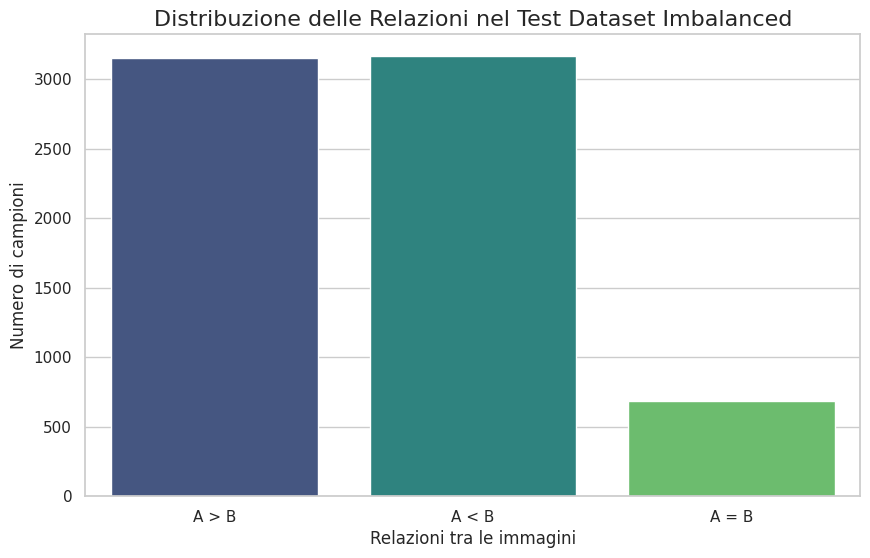

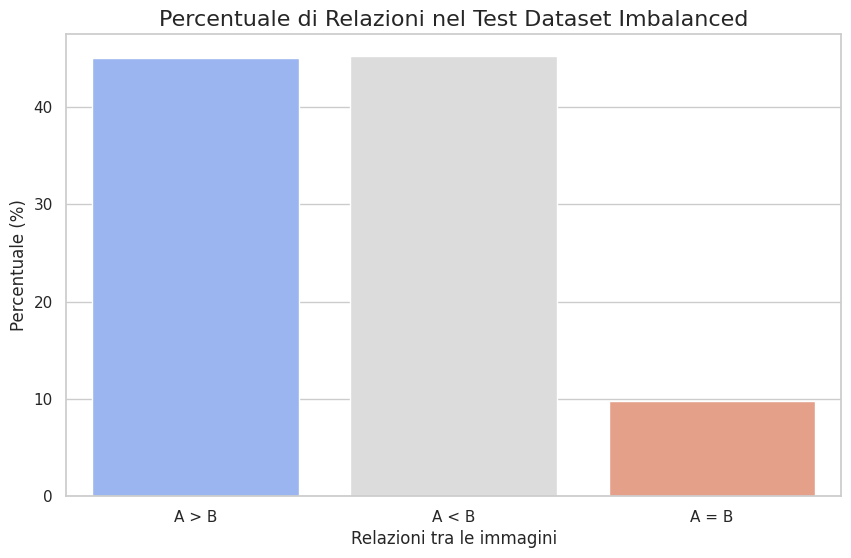

In [106]:
utils.plot_dataset_statistics(test_dataset_imbalanced, "Test Dataset Imbalanced")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 1356, 1: 1361, 2: 283}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 1356 campioni (45.20%)
Relazione 1: 1361 campioni (45.37%)
Relazione 2: 283 campioni (9.43%)




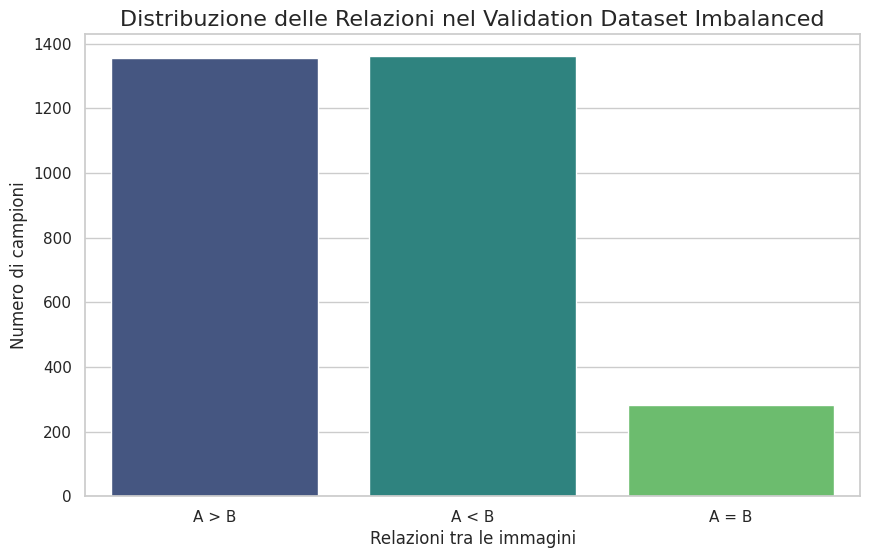

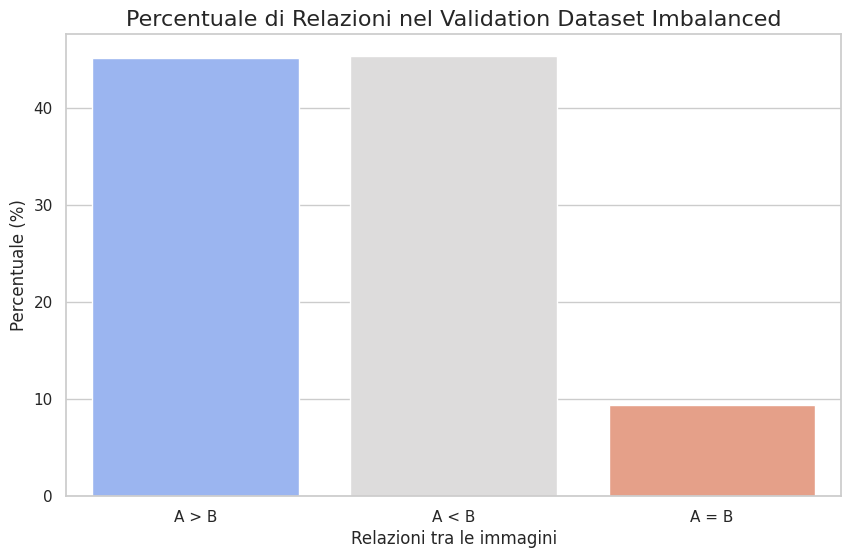

In [107]:
utils.plot_dataset_statistics(validation_dataset_imbalanced, "Validation Dataset Imbalanced")

In [108]:
train_dataset, train_dataset_raw = utils.create_train_dataset_MLP(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset_MLP(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


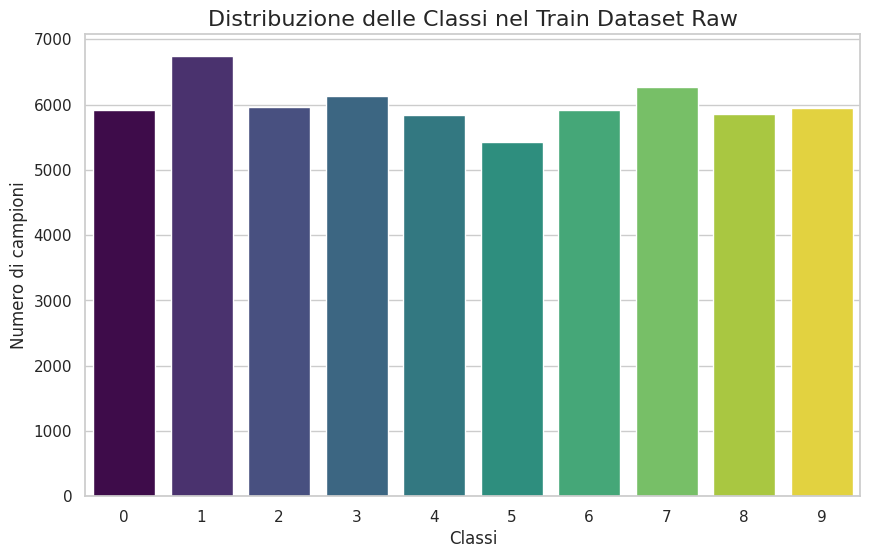

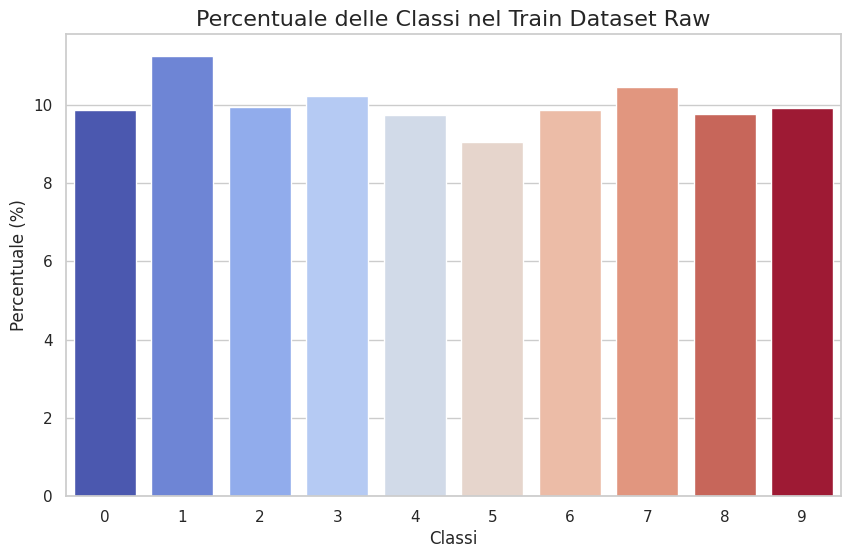

In [109]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 20000, 1: 20000, 0: 20000}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 0: 20000 campioni (33.33%)




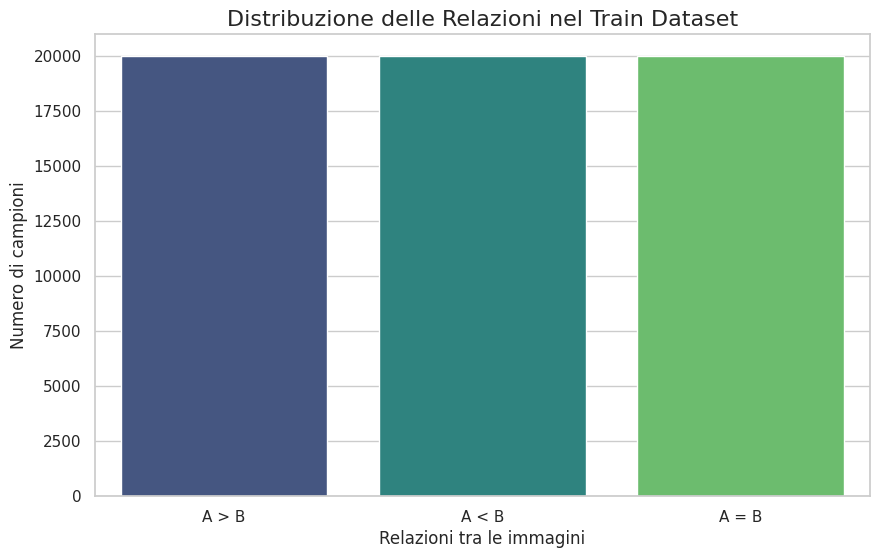

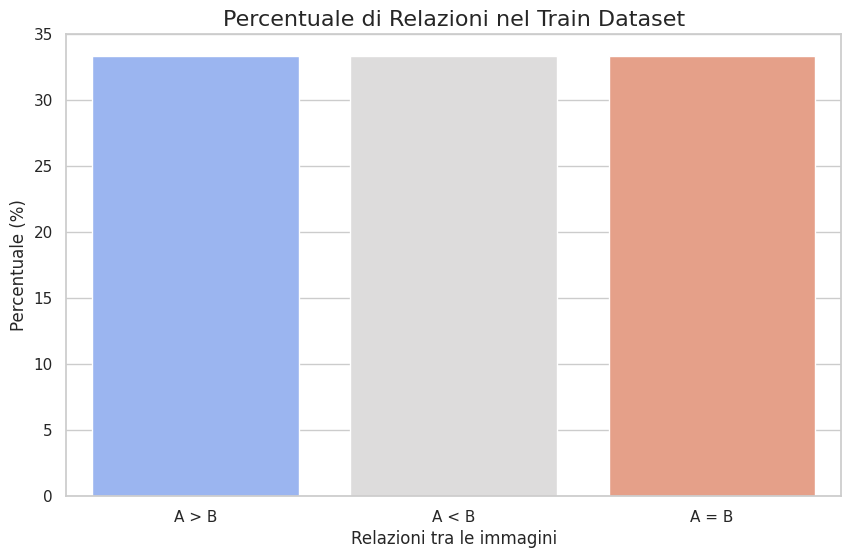

In [110]:
utils.plot_dataset_statistics_MLP(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 989, 2: 1015, 1: 996}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 0: 989 campioni (32.97%)
Relazione 2: 1015 campioni (33.83%)
Relazione 1: 996 campioni (33.20%)




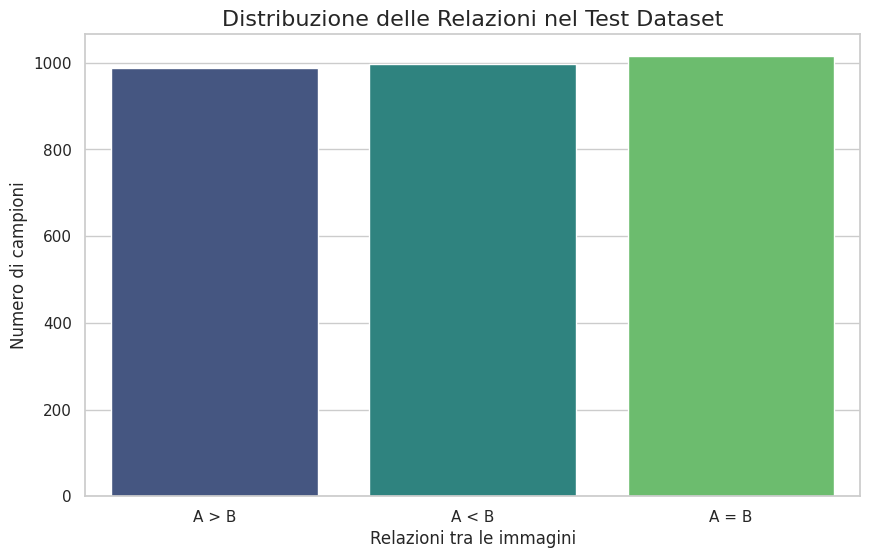

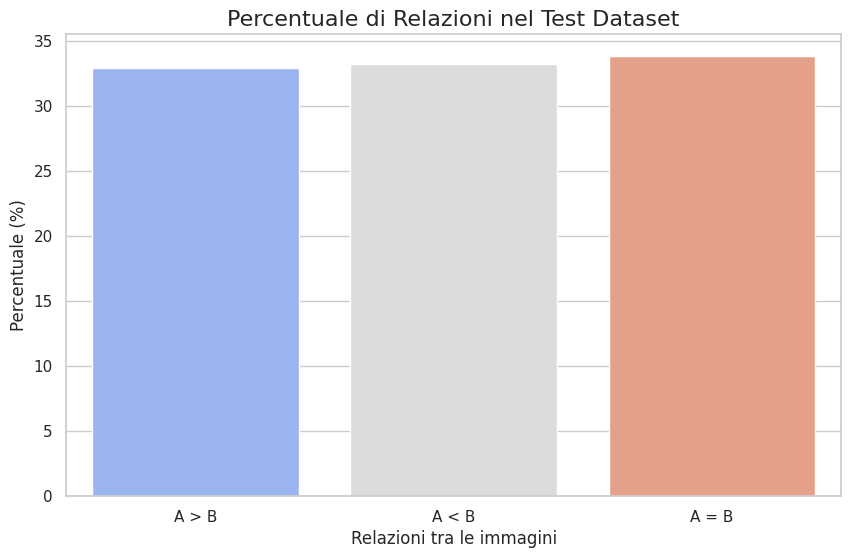

In [111]:
utils.plot_dataset_statistics_MLP(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 2318, 1: 2337, 0: 2344}
Dimensioni delle immagini trovate nel dataset: img_A -> torch.Size([1, 32, 32]) img_B -> torch.Size([1, 32, 32])
Relazione 2: 2318 campioni (33.12%)
Relazione 1: 2337 campioni (33.39%)
Relazione 0: 2344 campioni (33.49%)




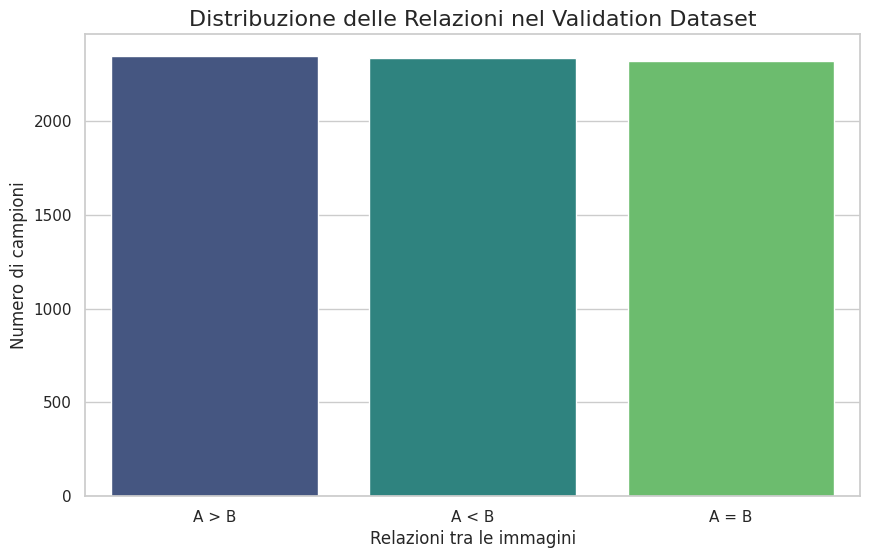

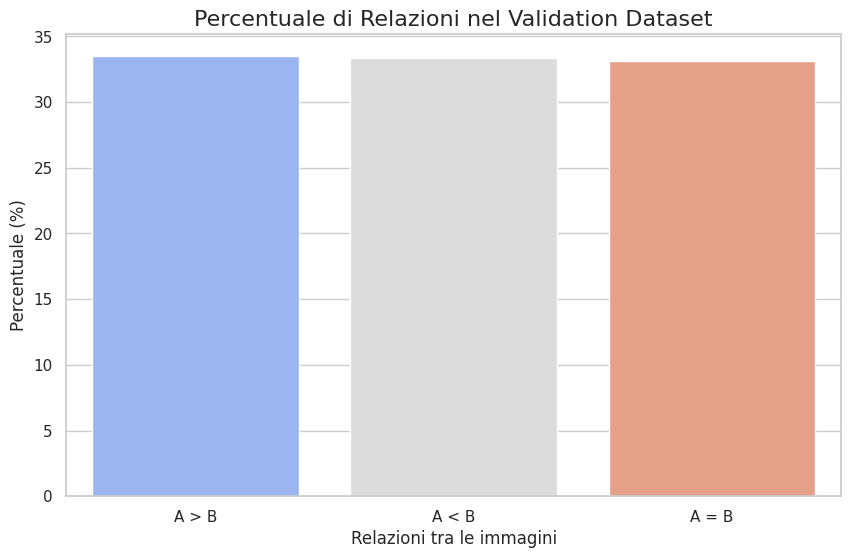

In [112]:
utils.plot_dataset_statistics_MLP(validation_dataset, dataset_name="Validation Dataset")

In [113]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [114]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [136]:
import torch.nn as nn
import torch.nn.functional as F

class NumberRecognitionCNN(nn.Module):
    def __init__(self):
        super(NumberRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Singola immagine, quindi 1 canale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classi per i numeri da 0 a 9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 10 classi (softmax potrebbe essere applicato esternamente)
        return x


In [137]:
class ComparisonMLP(nn.Module):
    def __init__(self):
        super(ComparisonMLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Prende 2 numeri in input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 classi (A > B, A < B, A = B)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output con 3 classi
        return x


In [138]:
class NumberComparisonModel(nn.Module):
    def __init__(self):
        super(NumberComparisonModel, self).__init__()
        self.cnn = NumberRecognitionCNN()  # Modello CNN per il riconoscimento dei numeri
        self.mlp = ComparisonMLP()  # MLP per confrontare i due numeri

    def load_cnn_weights(self, path):
        # Caricare i pesi della CNN da un file salvato
        self.cnn.load_state_dict(torch.load(path))
        # Bloccare i gradienti della CNN per non addestrarla nuovamente
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, img1: torch.Tensor, img2: torch.Tensor):
        # Riconoscimento del numero in ciascuna immagine
        num1 = self.cnn(img1)
        num2 = self.cnn(img2)

        # Convertire l'output della CNN in numeri predetti
        num1 = F.softmax(num1, dim=1).argmax(dim=1)
        num2 = F.softmax(num2, dim=1).argmax(dim=1)

        # Convertire i numeri in tensori float per il confronto
        num1 = num1.float()
        num2 = num2.float()

        # Combinare i numeri riconosciuti per passarli alla MLP
        numbers = torch.stack((num1, num2), dim=1)
        comparison = self.mlp(numbers)
        
        return num1, num2, comparison


In [139]:
model = NumberComparisonModel()

model.load_cnn_weights('weights/lenet5_best_weights.pth')
model.to(device)

criterion = nn.CrossEntropyLoss()

if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.mlp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.mlp.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

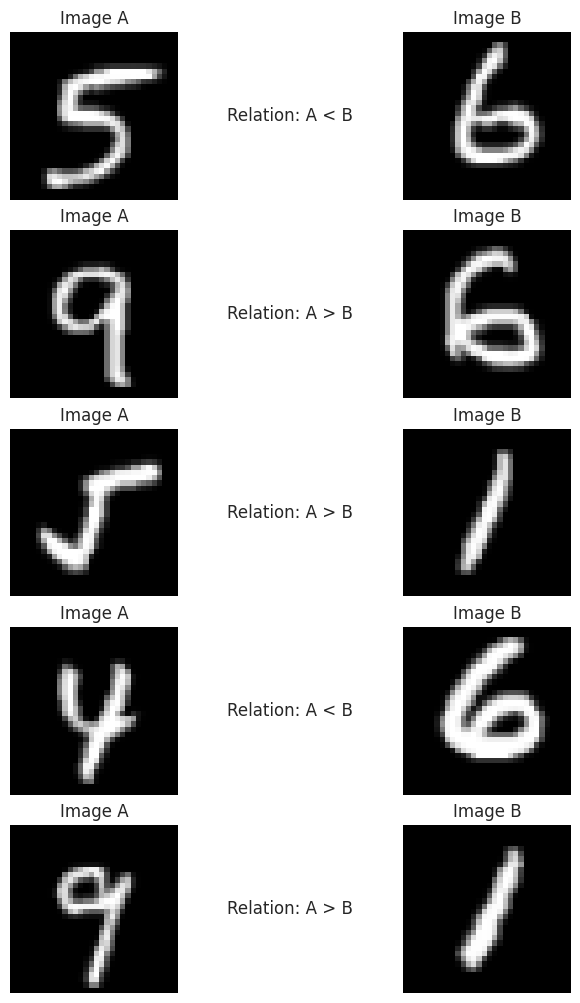

In [140]:
from torch.utils.tensorboard import SummaryWriter

# Definisci il fileName in base all'ottimizzatore
if OPTIMIZER == 'SGD':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/logMLP_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
imgs_A, imgs_B, labels = batch

# Dividi il batch in due immagini (img_A e img_B)
img_A, img_B = imgs_A[0], imgs_B[0]

# Ensure both tensors are of the same dtype
img_A = img_A.to(device)
img_B = img_B.to(device)

# Aggiungi entrambi gli input al grafo del modello
writer.add_graph(model, (img_A, img_B))

# Visualizza un esempio di coppia di immagini
writer.add_figure('Image_pair', utils.show_dataset_MLP(train_loader, 5))


In [141]:
def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)

        optimizer.zero_grad()

        num1, num2, outputs = model(img_A, img_B)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        img_A, img_B, labels = data

        img_A, img_B, labels = img_A.to(device), img_B.to(device), labels.to(device)
        
        with torch.no_grad():
            num1, num2, outputs = model(img_A, img_B)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [142]:
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
learning_rates = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalar('Learning Rate', current_lr, epoch + 1)
        #writer.add_scalar('Train Loss', train_loss, epoch + 1)
        #writer.add_scalar('Validation Loss', val_loss, epoch + 1)
        #writer.add_scalar('Train Accuracy', train_acc, epoch + 1)
        #writer.add_scalar('Validation Accuracy', val_acc, epoch + 1)
        
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)
        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 10
Training


Loss: 0.6937: 100%|██████████| 469/469 [00:08<00:00, 57.42it/s]


Validating


Loss: 0.7401: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s]


Epoch #1 train loss: 0.848 train accuracy: 80.49
Epoch #1 validation loss: 0.740 validation accuracy: 93.11
Learning rate actual:  0.0001
Took 0.152 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 10
Training


Loss: 0.5240: 100%|██████████| 469/469 [00:08<00:00, 58.58it/s]


Validating


Loss: 0.5947: 100%|██████████| 55/55 [00:00<00:00, 56.37it/s]


Epoch #2 train loss: 0.606 train accuracy: 93.79
Epoch #2 validation loss: 0.595 validation accuracy: 92.30
Learning rate actual:  0.0001
Took 0.150 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 10
Training


Loss: 0.4341: 100%|██████████| 469/469 [00:07<00:00, 58.78it/s]


Validating


Loss: 0.5046: 100%|██████████| 55/55 [00:00<00:00, 56.64it/s]


Epoch #3 train loss: 0.476 train accuracy: 94.18
Epoch #3 validation loss: 0.505 validation accuracy: 93.56
Learning rate actual:  0.0001
Took 0.149 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 10
Training


Loss: 0.3047: 100%|██████████| 469/469 [00:07<00:00, 59.01it/s]


Validating


Loss: 0.4434: 100%|██████████| 55/55 [00:00<00:00, 63.12it/s]


Epoch #4 train loss: 0.394 train accuracy: 94.50
Epoch #4 validation loss: 0.443 validation accuracy: 93.56
Learning rate actual:  0.0001
Took 0.147 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 10
Training


Loss: 0.3063: 100%|██████████| 469/469 [00:08<00:00, 57.76it/s]


Validating


Loss: 0.3970: 100%|██████████| 55/55 [00:00<00:00, 65.67it/s]


Epoch #5 train loss: 0.338 train accuracy: 94.84
Epoch #5 validation loss: 0.397 validation accuracy: 94.23
Learning rate actual:  0.0001
Took 0.149 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 10
Training


Loss: 0.2978: 100%|██████████| 469/469 [00:08<00:00, 57.96it/s]


Validating


Loss: 0.3614: 100%|██████████| 55/55 [00:00<00:00, 61.59it/s]


Epoch #6 train loss: 0.298 train accuracy: 95.26
Epoch #6 validation loss: 0.361 validation accuracy: 94.91
Learning rate actual:  0.0001
Took 0.150 minutes for epoch 6
Checkpoint saved at epoch 6.

EPOCH 7 of 10
Training


Loss: 0.2336: 100%|██████████| 469/469 [00:08<00:00, 57.26it/s]


Validating


Loss: 0.3319: 100%|██████████| 55/55 [00:00<00:00, 65.78it/s]


Epoch #7 train loss: 0.266 train accuracy: 95.76
Epoch #7 validation loss: 0.332 validation accuracy: 94.91
Learning rate actual:  0.0001
Took 0.151 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 10
Training


Loss: 0.2315: 100%|██████████| 469/469 [00:09<00:00, 51.02it/s]


Validating


Loss: 0.3059: 100%|██████████| 55/55 [00:01<00:00, 50.16it/s]


Epoch #8 train loss: 0.239 train accuracy: 96.13
Epoch #8 validation loss: 0.306 validation accuracy: 95.49
Learning rate actual:  0.0001
Took 0.172 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 10
Training


Loss: 0.2314: 100%|██████████| 469/469 [00:09<00:00, 47.04it/s]


Validating


Loss: 0.2840: 100%|██████████| 55/55 [00:01<00:00, 47.08it/s]


Epoch #9 train loss: 0.216 train accuracy: 96.84
Epoch #9 validation loss: 0.284 validation accuracy: 96.97
Learning rate actual:  0.0001
Took 0.186 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 10
Training


Loss: 0.2097: 100%|██████████| 469/469 [00:09<00:00, 49.31it/s]


Validating


Loss: 0.2658: 100%|██████████| 55/55 [00:01<00:00, 53.59it/s]


Epoch #10 train loss: 0.196 train accuracy: 97.68
Epoch #10 validation loss: 0.266 validation accuracy: 96.97
Learning rate actual:  0.0001
Took 0.176 minutes for epoch 10
Checkpoint saved at epoch 10.
Validating


Loss: 0.1674: 100%|██████████| 24/24 [00:00<00:00, 55.34it/s]

Test loss: 0.167 Test accuracy: 97.13


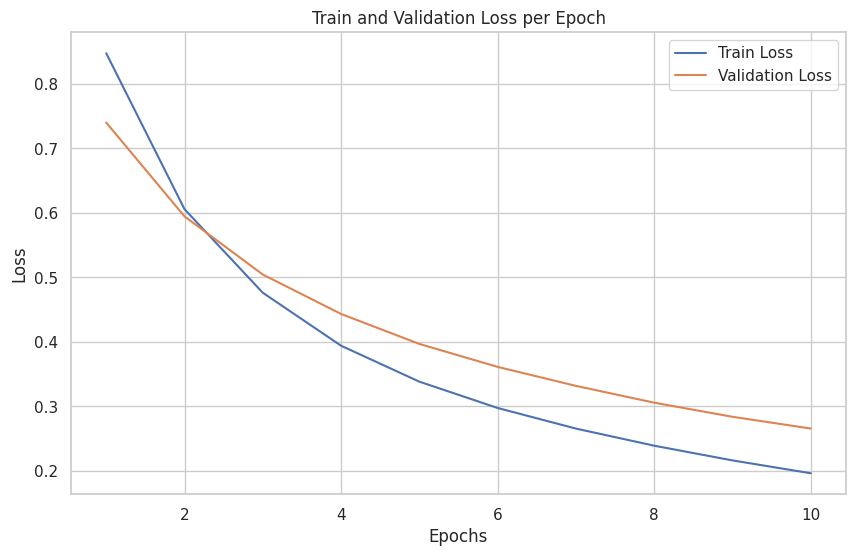

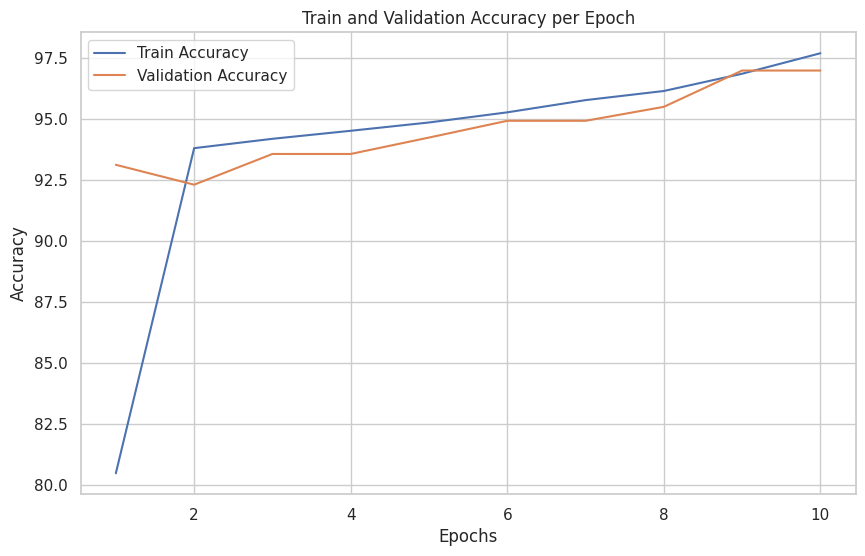

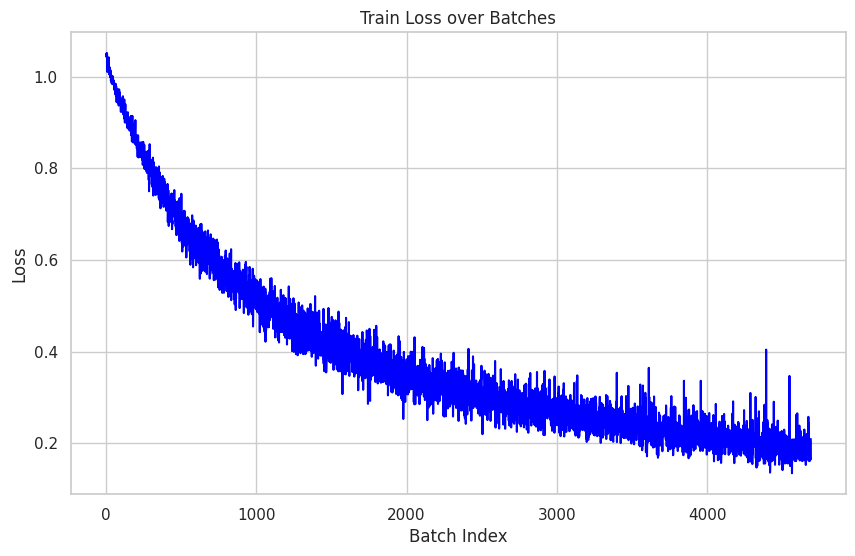

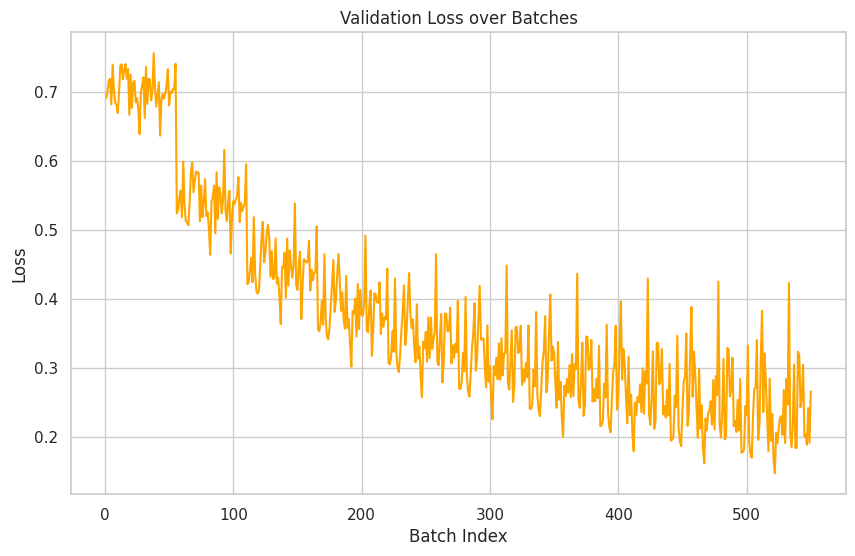

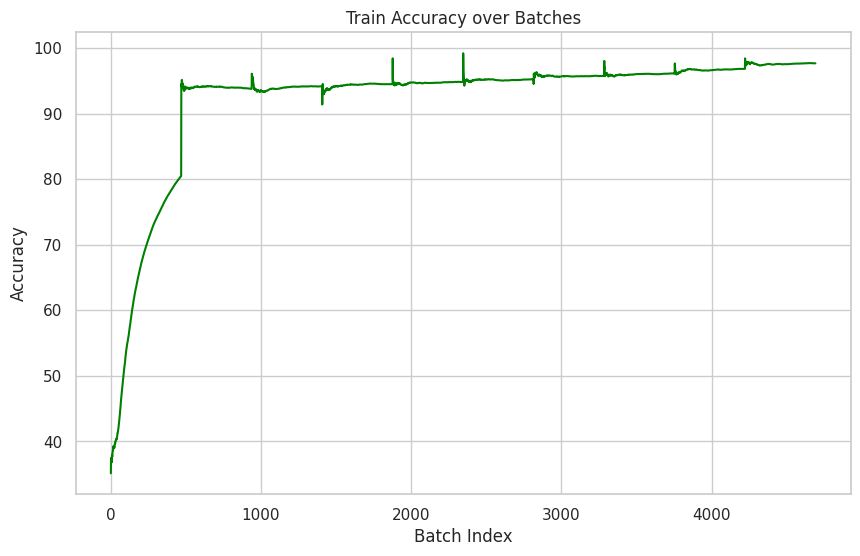

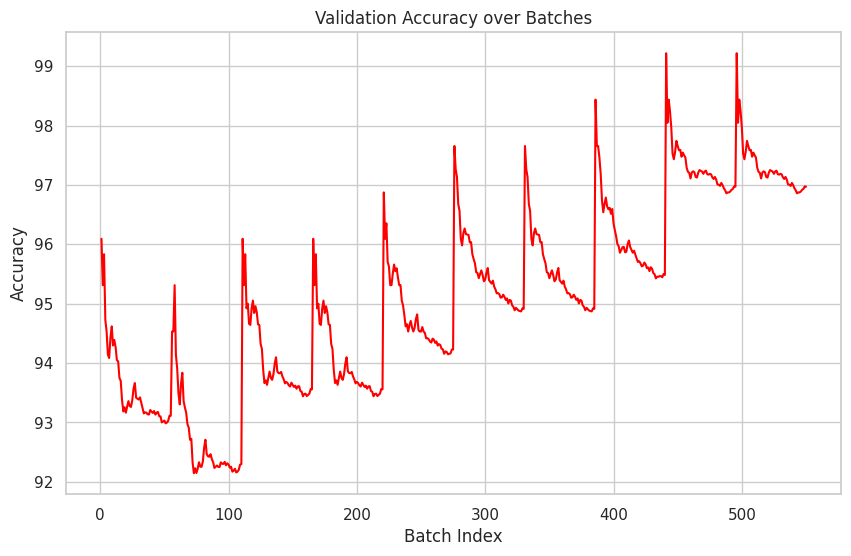

In [143]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

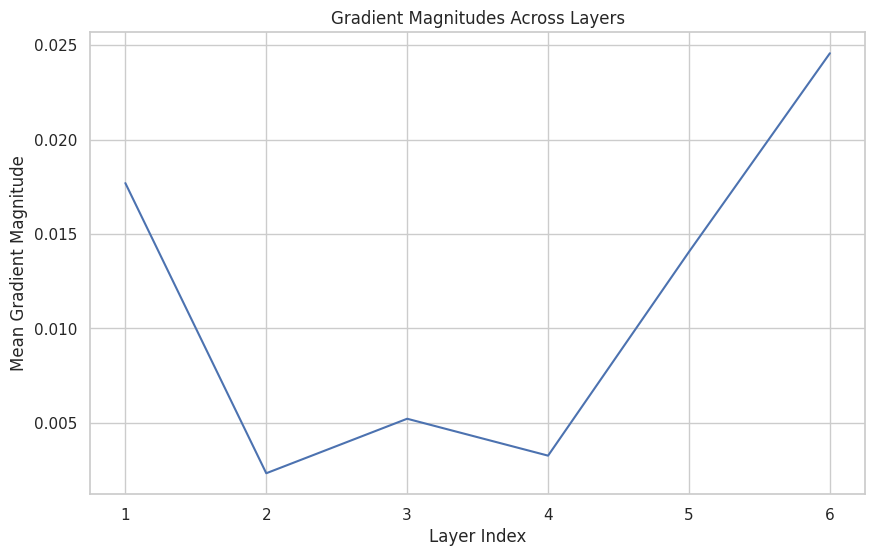

In [144]:
utils.plot_gradient(model)

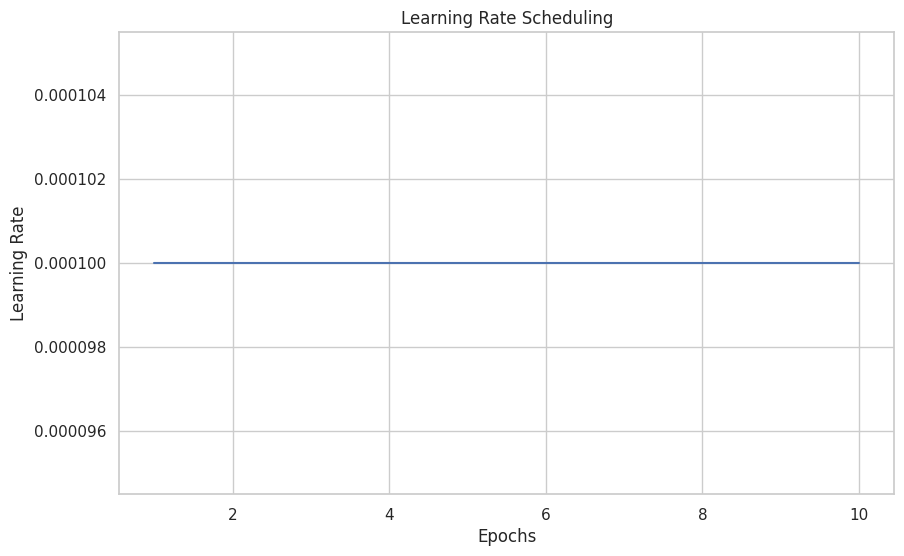

In [145]:
utils.plot_lr_scheduler(learning_rates)

In [146]:
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, all_num1_preds_test, all_num2_preds_test = utils.inference_MLP(model, test_loader, device)
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, all_num1_preds_val, all_num2_preds_val = utils.inference_MLP(model, validation_loader, device)

86 previsioni errate trovate.


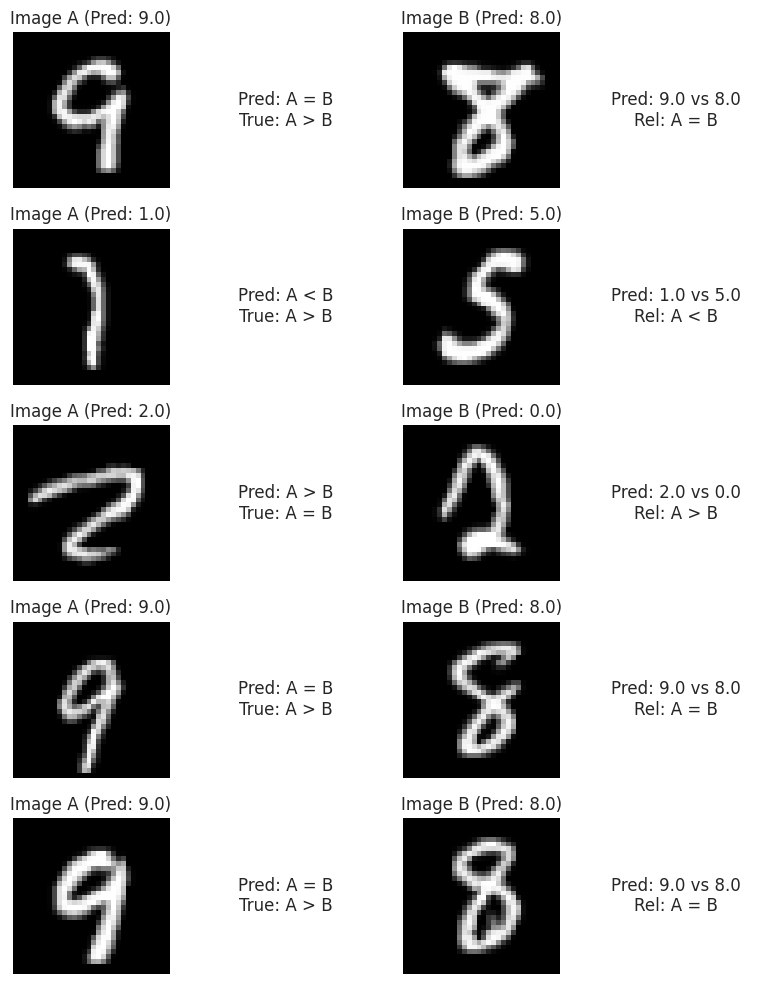

In [147]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions_MLP(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, all_num1_preds_test, all_num2_preds_test, 5))

In [ ]:
writer.add_figure('Incorrect_predictions_val', utils.show_incorrect_predictions_MLP(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, all_num1_preds_val, all_num2_preds_val, 5))

212 previsioni errate trovate.


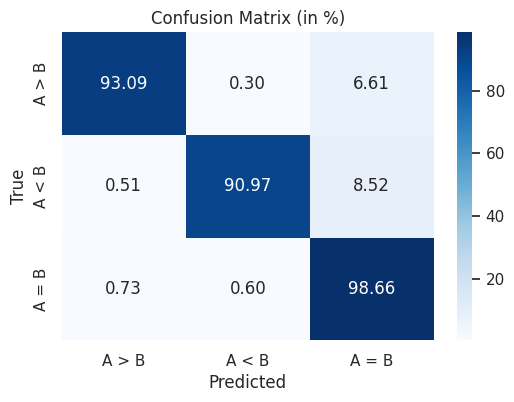

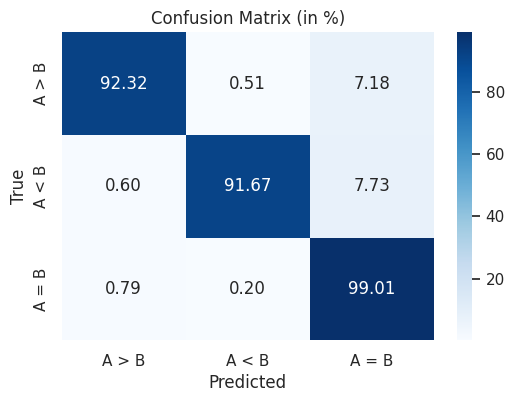

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)


              precision    recall  f1-score   support

       A > B       0.98      0.92      0.95       989
       A < B       0.99      0.92      0.95       996
       A = B       0.87      0.99      0.93      1015

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.95      0.94      0.94      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"runMLP_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main_MLP.ipynb')


Notebook saved as runMLP_BS=128_LR=0.0001_MOM=0.9_EPOCHS=5_AUG=False_TRA=False_OPT=SGD.ipynb


In [ ]:
writer.close()